In [3]:
import argparse
import numpy as np
import pandas as pd
import os
import random
import torch
import torch.nn as nn
import datetime
import time
import matplotlib.pyplot as plt
from torchinfo import summary
import yaml
import json
import sys
import glob
import copy
from tqdm import tqdm, trange
from torch.optim.lr_scheduler import LambdaLR, MultiStepLR, SequentialLR

sys.path.append("..")
from lib.utils import (
    MaskedMAELoss,
    MaskedHuberLoss,
    print_log,
    seed_everything,
    set_cpu_num,
    masked_mae_loss,
    CustomJSONEncoder,
    endpoint_adjacency,
    prop_graph_bce_loss,
)
from lib.metrics import RMSE_MAE_MAPE
from lib.data_prepare import get_dataloaders_from_index_data, load_inrix_data_with_details
from model.PropSTGformer import PropSTGformer
from functools import partial

/home/dachuan/anaconda3/envs/deep/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"
DATASET = "PROPSTGFORMER_INRIX_MANHATTAN"
SCALER = None

In [5]:
dataset = DATASET.upper()
data_path = f"data/{dataset}"
model_name = PropSTGformer.__name__
with open(f"model/{model_name}.yaml", "r") as f:
    cfg = yaml.safe_load(f)
cfg = cfg[dataset]

In [6]:
# ------------------------------- make log file ------------------------------ #

now = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
log_path = f"../logs/"
if not os.path.exists(log_path):
    os.makedirs(log_path)
log = os.path.join(log_path, f"{model_name}-{dataset}-{now}.log")
log = open(log, "a", encoding="utf-8")
log.seek(0)
log.truncate()

0

In [7]:
# ------------------------------- load dataset ------------------------------- #

print_log(dataset, log=log)
if 'INRIX' in dataset:
    (trainset_loader, valset_loader, testset_loader, SCALER, adj_mx, gdf, _) = (
        load_inrix_data_with_details(
            "/home/dachuan/Productivities/Spectral GAT/NY/adj_manhattan.npy",
            "/home/dachuan/Productivities/Spectral GAT/SPGAT/Data/speed_19_Manhattan_5min_py36",
            "/home/dachuan/Productivities/Spectral GAT/NY/Manhattan_FinalVersion.shp",
            "/home/dachuan/Productivities/Spectral GAT/NY/TMC_FinalVersion.csv",
            tod=cfg.get("time_of_day"),
            dow=cfg.get("day_of_week"),
            batch_size=cfg.get("batch_size", 64),
            history_seq_len=cfg.get("in_steps"),
            future_seq_len=cfg.get("out_steps"),
            log=log,
            train_ratio=cfg.get("train_size", 0.6),
            valid_ratio=cfg.get("val_size", 0.2),
            shift="store_true",
        )
    )

else:
    (trainset_loader, valset_loader, testset_loader, SCALER, adj_mx) = (
        get_dataloaders_from_index_data(
            data_path,
            tod=cfg.get("time_of_day"),
            dow=cfg.get("day_of_week"),
            batch_size=cfg.get("batch_size", 64),
            log=log,
            train_ratio=cfg.get("train_size", 0.6),
            valid_ratio=cfg.get("val_size", 0.2),
            shift="store_true",
        )
    )
print_log(log=log)

PROPSTGFORMER_INRIX_MANHATTAN
--- Building Sequences ---
--- Scaling Sequences ---
Trainset:	x-(63051, 1212, 12, 1)	y-(63051, 1212, 12, 1)
Valset:  	x-(21017, 1212, 12, 1)  	y-(21017, 1212, 12, 1)
Testset:	x-(21017, 1212, 12, 1)	y-(21017, 1212, 12, 1)



In [343]:
road = adj_mx[0]
# road = road.transpose() + road

In [344]:
import numpy as np
from itertools import combinations


def _neighbors(adj, i):
    """Return indices of neighbors of node i in an undirected graph."""
    return np.where(adj[i] != 0)[0]


def find_triangles(adj: np.ndarray) -> np.ndarray:
    """
    Find all triangles {i, j, k} with i < j < k.
    Returns: array of shape (M, 3)
    """
    N = adj.shape[0]
    triangles = []

    for i in trange(N):
        # neighbors of i with index > i to avoid duplicates
        nbrs_i = np.where(adj[i] != 0)[0]
        nbrs_i = nbrs_i[nbrs_i > i]
        for idx, j in enumerate(nbrs_i):
            # common neighbors between i and j with index > j
            # we only look among nbrs_i[idx+1:] to ensure i < j < k
            cand_k = nbrs_i[idx+1:]
            if cand_k.size == 0:
                continue
            # keep those k where edge j-k exists
            mask = adj[j, cand_k] != 0
            ks = cand_k[mask]
            for k in ks:
                triangles.append((i, j, k))

    return np.array(triangles, dtype=int) if triangles else np.zeros((0, 3), dtype=int)


def find_3_stars(adj: np.ndarray) -> np.ndarray:
    """
    Find all 3-stars: center + 3 distinct leaves.
    Returns rows [center, leaf1, leaf2, leaf3] (order of leaves arbitrary).
    Shape: (M, 4)  (N' = 4 nodes in the star)
    """
    N = adj.shape[0]
    stars = []

    for c in trange(N):
        nbrs = _neighbors(adj, c)
        if len(nbrs) < 3:
            continue
        for leaves in combinations(nbrs, 3):
            stars.append((c, *leaves))

    return np.array(stars, dtype=int) if stars else np.zeros((0, 4), dtype=int)


def find_4_stars(adj: np.ndarray) -> np.ndarray:
    """
    Find all 4-stars: center + 4 distinct leaves.
    Returns rows [center, leaf1, leaf2, leaf3, leaf4].
    Shape: (M, 5)
    """
    N = adj.shape[0]
    stars = []

    for c in trange(N):
        nbrs = _neighbors(adj, c)
        if len(nbrs) < 4:
            continue
        for leaves in combinations(nbrs, 4):
            stars.append((c, *leaves))

    return np.array(stars, dtype=int) if stars else np.zeros((0, 5), dtype=int)


def find_3_paths(adj: np.ndarray, induced: bool = True) -> np.ndarray:
    """
    Find all simple 3-node paths i - j - k.
    j is the middle node. i != k.
    If induced=True, require no edge between i and k (i.e., exclude triangles).
    Returns rows [i, j, k] with i < k for canonical orientation.
    Shape: (M, 3)
    """
    N = adj.shape[0]
    paths = []

    for j in trange(N):
        nbrs = _neighbors(adj, j)
        if len(nbrs) < 2:
            continue
        for i, k in combinations(nbrs, 2):
            if induced and adj[i, k] != 0:
                continue  # this would be part of a triangle, not a pure path
            # canonical orientation: smaller endpoint first
            if i < k:
                paths.append((i, j, k))
            else:
                paths.append((k, j, i))

    # deduplicate
    if not paths:
        return np.zeros((0, 3), dtype=int)
    paths = np.unique(np.array(paths, dtype=int), axis=0)
    return paths


def find_4_paths(adj: np.ndarray, induced: bool = True) -> np.ndarray:
    """
    Find all simple 4-node paths v0 - v1 - v2 - v3.
    We enforce all nodes distinct.
    If induced=True, we require no extra edges between non-consecutive nodes:
        no edges (v0,v2), (v0,v3), (v1,v3).
    Returns rows [v0, v1, v2, v3] in a canonical orientation
    (lexicographically smallest between path and its reverse).
    Shape: (M, 4)
    """
    N = adj.shape[0]
    path_set = set()

    for v1 in trange(N):
        nbrs1 = _neighbors(adj, v1)
        for v2 in nbrs1:
            if v2 == v1:
                continue
            nbrs0 = _neighbors(adj, v1)
            nbrs0 = nbrs0[nbrs0 != v2]
            nbrs3 = _neighbors(adj, v2)
            nbrs3 = nbrs3[nbrs3 != v1]

            for v0 in nbrs0:
                if v0 == v2:
                    continue
                for v3 in nbrs3:
                    if v3 in (v0, v1, v2):
                        continue
                    # induced path constraints
                    if induced:
                        if adj[v0, v2] != 0:
                            continue
                        if adj[v0, v3] != 0:
                            continue
                        if adj[v1, v3] != 0:
                            continue

                    path = (v0, v1, v2, v3)
                    rev = (v3, v2, v1, v0)
                    canon = min(path, rev)
                    path_set.add(canon)

    if not path_set:
        return np.zeros((0, 4), dtype=int)
    paths = np.array(sorted(path_set), dtype=int)
    return paths


def find_4_cycles(adj: np.ndarray, induced: bool = True) -> np.ndarray:
    """
    Find all simple 4-cycles (i - j - k - l - i) up to rotation / reflection.
    Implementation:
        - For each unordered pair (i,k) with i < k and NOT adjacent:
          find common neighbors S = N(i) ∩ N(k).
          Each unordered pair {j,l} ⊂ S gives cycle i-j-k-l-i.
        - If induced=True, require no chords: no edges (i,k) and (j,l).
    Returns rows [i, j, k, l] in a canonical orientation:
        smallest node first, second node = smallest neighbor of i in the cycle.
    Shape: (M, 4)
    """
    N = adj.shape[0]
    cycle_set = set()

    for i in trange(N):
        nbrs_i = _neighbors(adj, i)
        for k in range(i + 1, N):
            if adj[i, k] != 0:
                # for an induced 4-cycle, i and k should be non-adjacent (opposite nodes)
                if induced:
                    continue
            # common neighbors of i and k
            nbrs_k = _neighbors(adj, k)
            common = np.intersect1d(nbrs_i, nbrs_k, assume_unique=False)
            if len(common) < 2:
                continue
            # choose unordered pairs {j, l} in common
            for j, l in combinations(common, 2):
                if j == l:
                    continue
                # Induced: require j and l not adjacent
                if induced and adj[j, l] != 0:
                    continue
                # Now we have a 4-cycle i - j - k - l - i, up to rotation / reflection.
                cycle = (i, j, k, l)
                # Canonicalize cycle: rotate so smallest node is first,
                # then choose orientation (clockwise/counter) that is lexicographically smallest.
                cyc_variants = [
                    cycle,
                    (j, k, l, i),
                    (k, l, i, j),
                    (l, i, j, k),
                ]
                # reverse (reflections)
                cyc_variants += [tuple(reversed(c)) for c in cyc_variants]
                canon = min(cyc_variants)
                cycle_set.add(canon)

    if not cycle_set:
        return np.zeros((0, 4), dtype=int)
    cycles = np.array(sorted(cycle_set), dtype=int)
    return cycles


def build_motif_hypergraphs(adj: np.ndarray):
    """
    Convenience wrapper that returns a dict of motif tables:
    {
        'triangles': (M1, 3),
        '3-stars':   (M2, 4),
        '4-stars':   (M3, 5),
        '3-paths':   (M4, 3),
        '4-paths':   (M5, 4),
        '4-cycles':  (M6, 4),
    }
    """
    return {
        'triangles': find_triangles(adj),
        '3-stars':   find_3_stars(adj),
        '4-stars':   find_4_stars(adj),
        '3-paths':   find_3_paths(adj, induced=True),
        '4-paths':   find_4_paths(adj, induced=True),
        '4-cycles':  find_4_cycles(adj, induced=True),
    }


In [360]:
motifs = build_motif_hypergraphs(road)

100%|██████████| 1212/1212 [00:05<00:00, 229.11it/s]


In [ ]:
# motif_4_paths = np.sort(motifs['4-paths'], axis=1)
# motif_3_stars = np.sort(motifs['3-stars'], axis=1)
# motif_4_stars = np.sort(motifs['4-stars'], axis=1)

In [361]:
motifs['triangles'].shape, motifs['3-stars'].shape, motifs['4-stars'].shape, motifs['3-paths'].shape, motifs['4-paths'].shape, motifs['4-cycles'].shape

((0, 3), (219, 4), (13, 5), (937, 3), (2951, 4), (730, 4))

In [362]:
motifs['3-stars']

array([[   3,    4,    5,    6],
       [   7,    8,    9,   10],
       [  11,   36,   37,   38],
       [  11,   36,   37,   39],
       [  11,   36,   38,   39],
       [  11,   37,   38,   39],
       [  12,    4,    5,    6],
       [  15,   16,   17,   18],
       [  18,  406,  407,  408],
       [  26,   30,   31,   32],
       [  32,  221,  222,  223],
       [  38,   42,   43,   44],
       [  51,   47,   49,   52],
       [  59,  104,  105,  106],
       [  68,  981,  982,  983],
       [  76,   73,   75,   77],
       [ 100,  148,  149,  150],
       [ 111,    4,    5,    6],
       [ 112,  113,  114,  115],
       [ 115,  111,  112,  116],
       [ 116,  117,  118,  119],
       [ 118,  111,  112,  116],
       [ 124,  123,  125,  129],
       [ 125,  126,  127,  128],
       [ 126,  609,  610,  611],
       [ 126,  609,  610,  612],
       [ 126,  609,  611,  612],
       [ 126,  610,  611,  612],
       [ 127,  123,  125,  129],
       [ 131,  123,  125,  129],
       [ 1

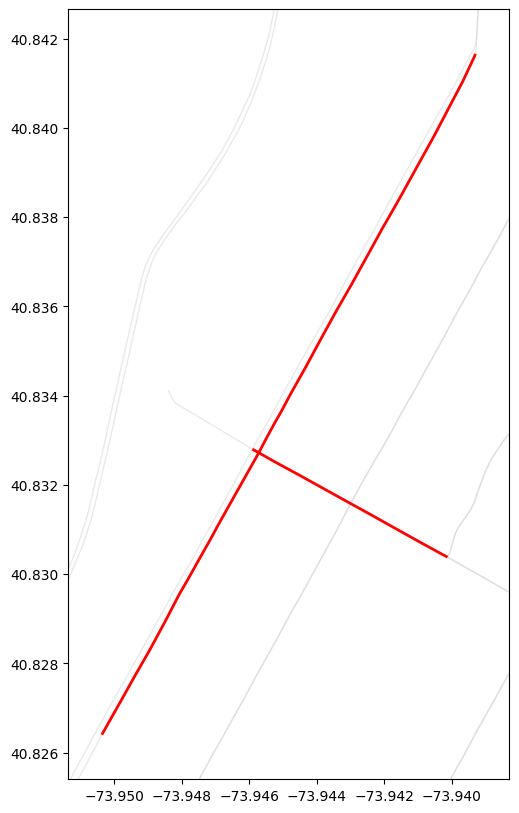

In [364]:
highlight_ids = motifs['3-stars'][207]

zoom_in = True

fig, ax = plt.subplots(figsize=(10, 10))

# base plot
gdf.plot(ax=ax, color="lightgray", linewidth=1, alpha=0.5)

# highlighted links
gdf.iloc[highlight_ids].plot(ax=ax, color="red", linewidth=2)

# ----- ZOOM ONTO HIGHLIGHTED AREA -----
# compute total bounds of all highlighted geometries
xmin, ymin, xmax, ymax = gdf.iloc[highlight_ids].total_bounds

if zoom_in:
    # # optionally expand slightly (padding)
    pad = 1e-3   # adjust meters/units as appropriate
    ax.set_xlim(xmin - pad, xmax + pad)
    ax.set_ylim(ymin - pad, ymax + pad)
else:
    pass

plt.show()

In [59]:
# ------------------------------- next graph inference ------------------------------- #
with torch.no_grad():
    x_batch, y_batch = next(iter(testset_loader))
    x_batch = x_batch.to(DEVICE)
    y_batch = y_batch.to(DEVICE)

In [90]:
import numpy as np

def extract_coarse_paths(adj: np.ndarray, min_nodes: int = 1):
    """
    Extract coarse paths from an undirected adjacency matrix (N,N).

    Coarse path = maximal chain v0 - v1 - ... - vK
        • internal nodes have degree == 2
        • endpoints have degree != 2   (includes deg 0, 1, 3, ...)
        • if deg == 0 → single-node path [u]

    Parameters
    ----------
    adj : np.ndarray
        Undirected adjacency matrix (N,N).
    min_nodes : int
        Minimum nodes to keep a path (default keeps singletons).

    Returns
    -------
    paths : list[list[int]]
        Each item is a list of node indices forming one coarse path.
    """
    N = adj.shape[0]
    deg = (adj != 0).sum(axis=1).astype(int)

    # Endpoint nodes include deg=0,1,3,4,...
    endpoints = np.where(deg != 2)[0]

    paths = []
    visited_edges = set()  # edges stored as (min, max)

    # Handle all isolated nodes (deg == 0)
    for u in np.where(deg == 0)[0]:
        paths.append([u])

    # Process all other endpoints
    for u in tqdm(endpoints):
        if deg[u] == 0:
            continue  # already handled isolated nodes

        nbrs = np.where(adj[u] != 0)[0]

        # For degree 1,2,3,... list neighbors normally
        for v in nbrs:
            e = (min(u, v), max(u, v))
            if e in visited_edges:
                continue

            # Start new path
            path = [u]
            prev = u
            curr = v
            visited_edges.add(e)

            # Walk until curr is no longer degree 2
            while deg[curr] == 2:
                nbrs_curr = np.where(adj[curr] != 0)[0]
                # pick the next node that isn't the previous
                nxt = nbrs_curr[0] if nbrs_curr[0] != prev else nbrs_curr[1]

                e_next = (min(curr, nxt), max(curr, nxt))
                if e_next in visited_edges:
                    break

                path.append(curr)
                visited_edges.add(e_next)
                prev, curr = curr, nxt

            # curr is an endpoint or visited boundary
            path.append(curr)

            if len(path) >= min_nodes:
                paths.append(path)

    return paths


In [91]:
coapaths = extract_coarse_paths(road)

100%|██████████| 730/730 [00:00<00:00, 115310.58it/s]


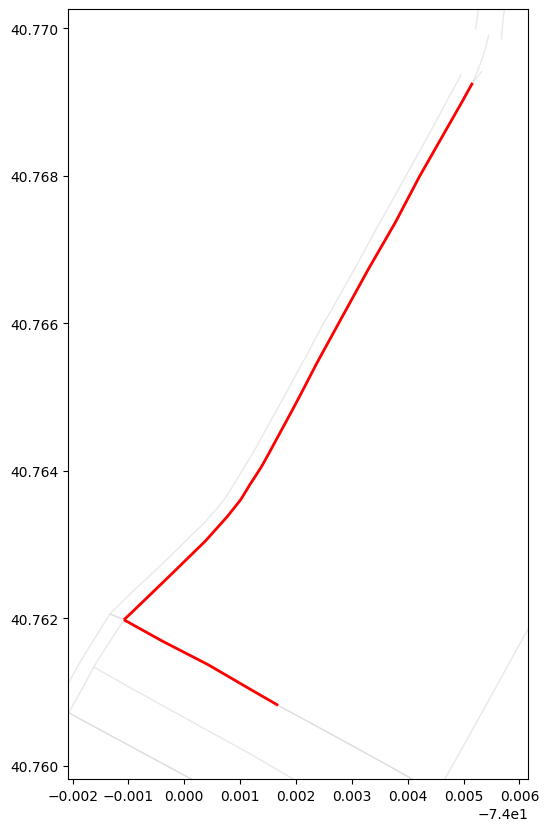

In [152]:
highlight_ids = coapaths[582]

fig, ax = plt.subplots(figsize=(10, 10))

# base plot
gdf.plot(ax=ax, color="lightgray", linewidth=1, alpha=0.5)

# highlighted links
gdf.iloc[highlight_ids].plot(ax=ax, color="red", linewidth=2)

# ----- ZOOM ONTO HIGHLIGHTED AREA -----
# compute total bounds of all highlighted geometries
xmin, ymin, xmax, ymax = gdf.iloc[highlight_ids].total_bounds

# # optionally expand slightly (padding)
pad = 1e-3   # adjust meters/units as appropriate
ax.set_xlim(xmin - pad, xmax + pad)
ax.set_ylim(ymin - pad, ymax + pad)

plt.show()

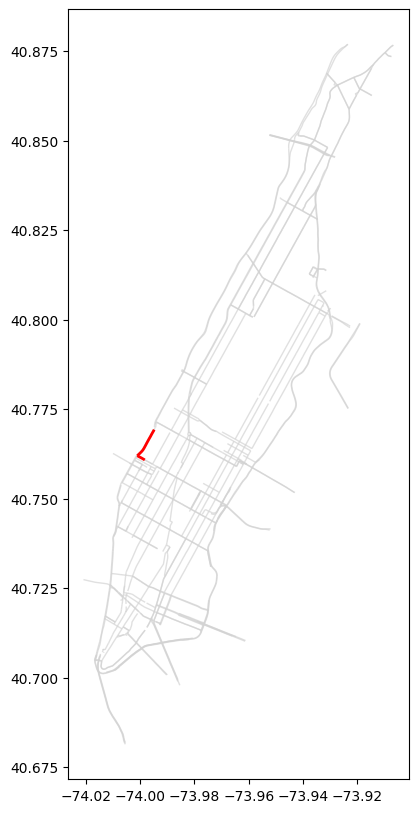

In [143]:
highlight_nodes = coapaths[582]

# Base plot (all nodes/segments)
ax = gdf.plot(figsize=(10,10), color="lightgray", linewidth=1, alpha=0.7)

# Highlighted nodes
gdf.iloc[highlight_nodes].plot(ax=ax, color="red", linewidth=2)

plt.show()

In [104]:
road[coapaths[582]][0].sum()

5

In [132]:
import networkx as nx
import momepy

In [211]:
import networkx as nx
import momepy as mm

def build_intersection_graph(streets_gdf):
    """
    Build a symmetric intersection graph from a GeoDataFrame of street segments,
    and attach 'seg_idx' = original row index of the street segment.
    """
    # Create a copy and add an integer ID column
    streets_gdf = streets_gdf.copy()
    streets_gdf = streets_gdf.reset_index().rename(columns={"index": "TMC"})
    streets_gdf["seg_idx"] = streets_gdf.index.values

    # momepy primal graph
    G_raw = mm.gdf_to_nx(streets_gdf, approach="primal")

    # Force undirected & simple graph
    if G_raw.is_directed():
        G_und = G_raw.to_undirected()
    else:
        G_und = G_raw

    # Create a simple Graph (not MultiGraph)
    G = nx.Graph()
    for u, v, data in G_und.edges(data=True):
        # If parallel edges exist, just keep the first
        if not G.has_edge(u, v):
            G.add_edge(u, v, **data)

    # Copy node attributes
    for n, d in G_und.nodes(data=True):
        if n not in G:
            G.add_node(n, **d)

    return G


def extract_degree2_paths(G):
    """
    Return coarse paths AND the list of segment indices along each path.
    """
    deg = dict(G.degree())
    endpoints = [n for n, d in deg.items() if d != 2]

    paths_nodes = []
    paths_seg_idx = []
    visited = set()

    for start in endpoints:
        for nbr in G.neighbors(start):
            e = tuple(sorted((start, nbr)))
            if e in visited:
                continue

            # Initialize path
            path_nodes = [start, nbr]
            path_seg = [G[start][nbr]["seg_idx"]]

            visited.add(e)

            prev, curr = start, nbr

            # Walk forward until reaching a non-degree-2 node
            while deg[curr] == 2:
                nbrs_curr = [x for x in G.neighbors(curr) if x != prev]
                if not nbrs_curr:
                    break

                nxt = nbrs_curr[0]
                e2 = tuple(sorted((curr, nxt)))
                if e2 in visited:
                    break

                path_nodes.append(nxt)
                path_seg.append(G[curr][nxt]["seg_idx"])
                visited.add(e2)

                prev, curr = curr, nxt

            # Only keep paths whose endpoints are degree != 2
            if deg[path_nodes[-1]] != 2:
                paths_nodes.append(path_nodes)
                paths_seg_idx.append(path_seg)

    return paths_nodes, paths_seg_idx


def get_segment_paths(streets_gdf):
    """
    Returns:
      G               : the full intersection graph
      paths_nodes     : list of node sequences
      paths_seg_idx   : list of segment index sequences (into streets_gdf)
    """
    G = build_intersection_graph(streets_gdf)
    paths_nodes, paths_seg_idx = extract_degree2_paths(G)
    return G, paths_nodes, paths_seg_idx


In [212]:
# streets_gdf: your GeoDataFrame of city segments
G, paths_nodes, paths_edges = get_segment_paths(gdf)

/home/dachuan/anaconda3/envs/deep/lib/python3.12/site-packages/momepy/utils.py:351: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_network[length] = gdf_network.geometry.length


(array([  0., 176., 103.,  51.,  24.,   7.,   6.,   5.,   4.,   2.,   3.,
          3.,   4.,   1.,   0.,   1.,   0.,   0.,   1.,   1.,   0.,   0.,
          1.,   1.,   0.,   0.,   0.,   0.,   0.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29.]),
 <BarContainer object of 29 artists>)

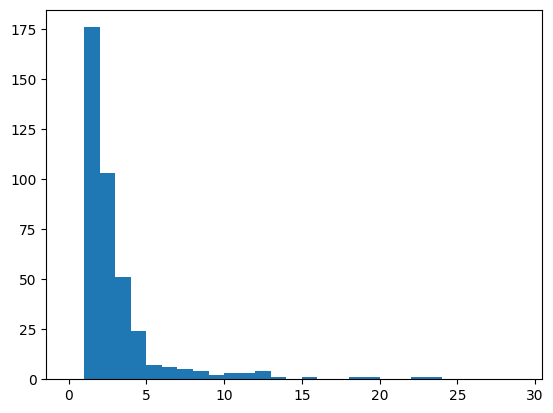

In [333]:
path_lengths = [len(p) for p in paths_edges]
plt.hist(path_lengths, range(0, 30))

In [327]:
path_edges_flat = [p  for path in paths_edges for p in path ]

[443,
 0,
 1,
 2,
 968,
 1166,
 137,
 442,
 444,
 3,
 7,
 4,
 11,
 5,
 179,
 111,
 8,
 10,
 756,
 855,
 112,
 116,
 211,
 206,
 36,
 40,
 72,
 37,
 41,
 38,
 39,
 180,
 178,
 177,
 224,
 181,
 182,
 815,
 42,
 898,
 43,
 226,
 44,
 975,
 598,
 45,
 714,
 715,
 46,
 13,
 15,
 17,
 619,
 954,
 939,
 940,
 916,
 516,
 511,
 510,
 513,
 515,
 733,
 734,
 463,
 341,
 18,
 618,
 888,
 1031,
 377,
 376,
 375,
 201,
 404,
 403,
 407,
 963,
 542,
 543,
 544,
 1055,
 408,
 655,
 653,
 656,
 919,
 757,
 547,
 546,
 545,
 787,
 696,
 455,
 19,
 21,
 22,
 599,
 508,
 20,
 23,
 936,
 930,
 499,
 494,
 492,
 495,
 497,
 1011,
 1013,
 433,
 857,
 856,
 507,
 509,
 1094,
 600,
 601,
 603,
 858,
 28,
 25,
 26,
 30,
 220,
 32,
 194,
 190,
 189,
 221,
 370,
 373,
 827,
 823,
 306,
 223,
 372,
 1121,
 1101,
 992,
 890,
 891,
 892,
 1113,
 1049,
 1050,
 1051,
 192,
 191,
 193,
 592,
 589,
 977,
 807,
 803,
 802,
 804,
 225,
 423,
 262,
 816,
 1171,
 808,
 809,
 47,
 49,
 50,
 469,
 470,
 474,
 531,
 529,
 5

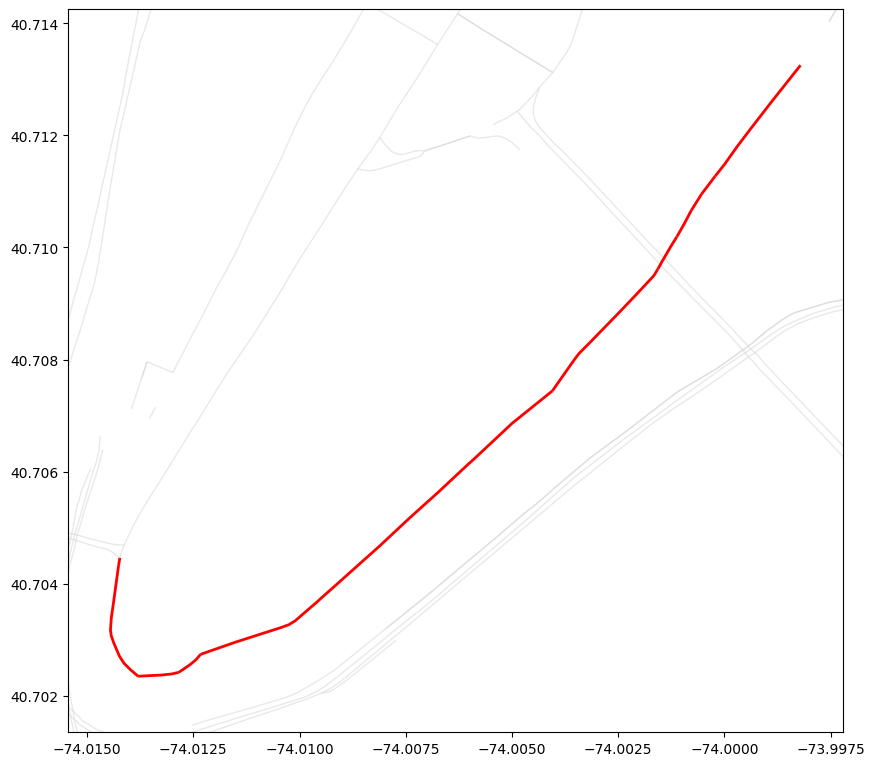

In [330]:
highlight_ids = paths_edges[41]

fig, ax = plt.subplots(figsize=(10, 10))

# base plot
gdf.plot(ax=ax, color="lightgray", linewidth=1, alpha=0.5)

# highlighted links
gdf.iloc[highlight_ids].plot(ax=ax, color="red", linewidth=2)

# ----- ZOOM ONTO HIGHLIGHTED AREA -----
# compute total bounds of all highlighted geometries
xmin, ymin, xmax, ymax = gdf.iloc[highlight_ids].total_bounds

# # optionally expand slightly (padding)
pad = 1e-3   # adjust meters/units as appropriate
ax.set_xlim(xmin - pad, xmax + pad)
ax.set_ylim(ymin - pad, ymax + pad)

plt.show()

In [238]:
import numpy as np
import networkx as nx

def get_edge_id(G, u, v):
    return G[u][v]["seg_idx"]


# -------------------------------
#  STAR MOTIFS
# -------------------------------
def find_k_star(G, k):
    """
    Return matrices:
       nodes: (N_star, k+1)
       edges: (N_star, k)
    """
    nodes_list = []
    edges_list = []

    node_order = list(G.nodes())
    node_to_pos = {n: i for i, n in enumerate(node_order)}

    for center in G.nodes():
        nbrs = list(G.neighbors(center))
        if len(nbrs) == k:
            # canonical order: sort by global node order
            nbrs_sorted = sorted(nbrs, key=lambda x: node_to_pos[x])
            row_nodes = [center] + nbrs_sorted
            row_nodes = sorted(row_nodes, key=lambda x: node_to_pos[x])

            row_edges = [get_edge_id(G, center, n) for n in nbrs_sorted]

            nodes_list.append(row_nodes)
            edges_list.append(row_edges)

    if len(nodes_list) == 0:
        return np.zeros((0, k+1), dtype=int), np.zeros((0, k), dtype=int)

    return np.array(nodes_list, dtype=int), np.array(edges_list, dtype=int)


# -------------------------------
# TRIANGLES
# -------------------------------
def find_triangles_matrix(G):
    node_order = list(G.nodes())
    node_to_pos = {n: i for i, n in enumerate(node_order)}

    tri_nodes = []
    tri_edges = []

    for cyc in nx.cycle_basis(G):
        if len(cyc) != 3:
            continue

        a, b, c = cyc
        # canonical node ordering
        cyc_sorted = sorted(cyc, key=lambda x: node_to_pos[x])

        edges = [
            get_edge_id(G, a, b),
            get_edge_id(G, b, c),
            get_edge_id(G, c, a),
        ]

        tri_nodes.append(cyc_sorted)
        tri_edges.append(edges)

    if len(tri_nodes) == 0:
        return np.zeros((0, 3), dtype=int), np.zeros((0, 3), dtype=int)

    return np.array(tri_nodes, dtype=int), np.array(tri_edges, dtype=int)


# -------------------------------
# 4-CYCLES
# -------------------------------
def is_induced_4cycle(G, nodes):
    """Exactly 4 edges inside subgraph + degree 2 each."""
    sub = G.subgraph(nodes)
    return sub.number_of_edges() == 4 and all(sub.degree(n) == 2 for n in sub.nodes())


def find_4cycles_matrix(G):
    node_order = list(G.nodes())
    node_to_pos = {n: i for i, n in enumerate(node_order)}

    cyc_nodes = []
    cyc_edges = []

    for cyc in nx.cycle_basis(G):
        if len(cyc) != 4:
            continue
        if not is_induced_4cycle(G, cyc):
            continue

        a, b, c, d = cyc

        cyc_sorted = sorted(cyc, key=lambda x: node_to_pos[x])
        edges = [
            get_edge_id(G, a, b),
            get_edge_id(G, b, c),
            get_edge_id(G, c, d),
            get_edge_id(G, d, a),
        ]

        cyc_nodes.append(cyc_sorted)
        cyc_edges.append(edges)

    if len(cyc_nodes) == 0:
        return np.zeros((0, 4), dtype=int), np.zeros((0, 4), dtype=int)

    return np.array(cyc_nodes, dtype=int), np.array(cyc_edges, dtype=int)


# -------------------------------
# MASTER WRAPPER
# -------------------------------
def find_motifs_matrix(G):
    """
    Returns dict:
    {
        "3-star":  {"nodes": (N3,4), "edges": (N3,3)},
        "4-star":  {"nodes": (N4,5), "edges": (N4,4)},
        "triangle":{"nodes": (Nt,3), "edges": (Nt,3)},
        "4-cycle": {"nodes": (Nc,4), "edges": (Nc,4)},
    }
    """
    n3_nodes, n3_edges = find_k_star(G, 3)
    n4_nodes, n4_edges = find_k_star(G, 4)
    tri_nodes, tri_edges = find_triangles_matrix(G)
    sq_nodes, sq_edges = find_4cycles_matrix(G)

    return {
        "3-star":  n3_edges,
        "4-star":  n4_edges,
        "triangle": tri_edges,
        "4-cycle": sq_edges,
    }


In [297]:
import torch
import networkx as nx
from collections import defaultdict


def build_adj_from_nx(G, device="cuda"):
    """
    Build a dense adjacency matrix (N x N) torch.bool from an undirected nx.Graph.
    Nodes are ordered as list(G.nodes()) and mapped to 0..N-1.

    Returns:
        adj      : (N, N) bool tensor on device
        node_list: list of original node IDs in order
        node_to_id: dict {original_node: idx}
    """
    node_list = list(G.nodes())
    node_to_id = {n: i for i, n in enumerate(node_list)}
    N = len(node_list)

    adj = torch.zeros((N, N), dtype=torch.bool, device=device)
    for u, v in G.edges():
        i = node_to_id[u]
        j = node_to_id[v]
        adj[i, j] = True
        adj[j, i] = True

    return adj, node_list, node_to_id


def enumerate_cycles_up_to_k(
    G,
    min_len=5,
    max_len=8,
    device="cuda",
):
    """
    GPU-accelerated simple cycle enumeration in an undirected graph, limited
    to cycle lengths in [min_len, max_len], with max_len <= 8 recommended.

    Args:
        G        : networkx.Graph (undirected, simple)
        min_len  : minimum cycle length (e.g., 5)
        max_len  : maximum cycle length (e.g., 8)
        device   : 'cuda' or 'cpu'

    Returns:
        cycles_by_len: dict {k: torch.LongTensor [Nk, k]}
            - cycles_by_len[k][r] is the r-th cycle of length k
            - entries are node indices (0..N-1) **in the order of G.nodes()**
        node_list    : list of original node IDs, so
                       original_ids = [node_list[i] for i in cycle_row]
    """
    assert min_len >= 3, "Cycles must have length >= 3"
    assert max_len >= min_len, "max_len must be >= min_len"

    # Build adjacency on GPU
    adj, node_list, node_to_id = build_adj_from_nx(G, device=device)
    N = adj.shape[0]

    # Store cycles by length as Python lists before converting to tensors
    cycles_by_len = defaultdict(list)

    # We'll do DFS from each start node `s`.
    # To avoid duplicates in an undirected graph:
    #  - enforce that `s` is the smallest node index in the cycle
    #  - when closing a cycle, also enforce that second node < last node
    #    (this removes reverse duplicates).
    def dfs(start, current, length, visited, path):
        """
        Recursively extend paths from 'current', starting at 'start'.

        Args:
            start   : starting node index (smallest in cycle by design)
            current : current node index
            length  : current path length (number of nodes in path)
            visited : (N,) bool tensor on device
            path    : Python list of node indices (on CPU)
        """

        if length > max_len:
            return

        # Tensor view to adjacency row of `current`
        neighbors_row = adj[current]

        # We will consider two types of neighbors:
        #  1. Potential cycle closure (neighbor == start)
        #  2. Path extension (neighbor > start and not visited)
        #
        # We'll first handle closure opportunities:
        if length >= min_len:
            # Check if we can close the cycle by going back to start
            if neighbors_row[start]:
                # path + [start] forms a cycle
                # To remove reversed duplicates, we enforce:
                #   second_node < last_node
                second_node = path[1]
                last_node = current
                if second_node < last_node:
                    # Accept this cycle
                    # NOTE: `path` is already a list of node indices.
                    cycles_by_len[length].append(path.copy())

        # If current length already equals max_len, no further extension
        if length == max_len:
            return

        # Build mask of extension candidates:
        #  - neighbor > start (enforces start is smallest)
        #  - neighbor not visited
        candidate_mask = neighbors_row.clone()
        # remove start (only use start for closure, handled above)
        candidate_mask[start] = False

        # visited is True for already in path; we cannot revisit
        candidate_mask = candidate_mask & (~visited)

        # enforce neighbor > start to keep start minimal in cycle
        if start + 1 < N:
            lower_mask = torch.zeros_like(candidate_mask)
            lower_mask[: start + 1] = True  # indices <= start should be masked out
            candidate_mask = candidate_mask & (~lower_mask)

        # Get candidate neighbors
        cand_idx = torch.nonzero(candidate_mask, as_tuple=False).flatten()

        # If no candidates, backtrack
        if cand_idx.numel() == 0:
            return

        # Convert candidate indices to CPU ints for recursion
        cand_idx_cpu = cand_idx.tolist()

        for nb in cand_idx_cpu:
            # Extend path
            visited_next = visited.clone()
            visited_next[nb] = True
            path.append(nb)
            dfs(start, nb, length + 1, visited_next, path)
            path.pop()

    # Main loop over start nodes
    for s in trange(N):
        # Prepare visited mask and path starting from s
        visited = torch.zeros(N, dtype=torch.bool, device=device)
        visited[s] = True
        neighbors = torch.nonzero(adj[s], as_tuple=False).flatten()

        # To enforce s being the smallest node in the cycle,
        # we only start with neighbors > s
        if s + 1 < N:
            nbr_mask = neighbors > s
            neighbors = neighbors[nbr_mask]

        neighbors_cpu = neighbors.tolist()

        for nb in neighbors_cpu:
            visited_next = visited.clone()
            visited_next[nb] = True
            path = [s, nb]  # current path nodes
            dfs(start=s, current=nb, length=2, visited=visited_next, path=path)

    # Convert to tensors by length
    cycles_tensors = {}
    for k in range(min_len, max_len + 1):
        cyc_list = cycles_by_len.get(k, [])
        if len(cyc_list) == 0:
            cycles_tensors[k] = torch.empty((0, k), dtype=torch.long)
        else:
            cycles_tensors[k] = torch.tensor(cyc_list, dtype=torch.long)

    return cycles_tensors, node_list

def cycles_to_edge_ids(G, cycles_by_len, node_list):
    """
    Convert cycle node-index tensors into edge-index tensors.

    Args:
        G              : networkx.Graph with edge attribute "seg_idx"
        cycles_by_len  : dict {k: LongTensor (Nk, k)}
        node_list      : list of original node IDs in order of the node indexing

    Returns:
        edges_by_len   : dict {k: LongTensor (Nk, k)}
            edges_by_len[k][i,j] = seg_idx of edge between cycle node j and j+1 (wrap)
    """
    edges_by_len = {}

    for k, cyc_tensor in cycles_by_len.items():
        if cyc_tensor.numel() == 0:
            # no cycles of this length
            edges_by_len[k] = torch.empty((0, k), dtype=torch.long)
            continue

        Nk = cyc_tensor.shape[0]
        edge_ids = torch.empty((Nk, k), dtype=torch.long)

        for i in range(Nk):
            cyc = cyc_tensor[i].tolist()    # cycle as node indices
            for j in range(k):
                u_idx = cyc[j]
                v_idx = cyc[(j + 1) % k]

                # original node IDs
                u = node_list[u_idx]
                v = node_list[v_idx]

                # undirected edge: use G[u][v]
                seg_id = G[u][v]["seg_idx"]
                edge_ids[i, j] = seg_id

        edges_by_len[k] = edge_ids

    return edges_by_len


In [300]:
cycles_by_len, node_list = enumerate_cycles_up_to_k(
    G,
    min_len=4,
    max_len=12,
    device="cuda",   # or "cpu" if debugging
)
k_cycles = cycles_to_edge_ids(G, cycles_by_len, node_list)

100%|██████████| 950/950 [00:05<00:00, 173.76it/s] 


In [309]:
k_cycles[5].shape

torch.Size([17, 5])

In [270]:
motifs = find_motifs_matrix(G)['4-star']
motifs.shape

(75, 4)

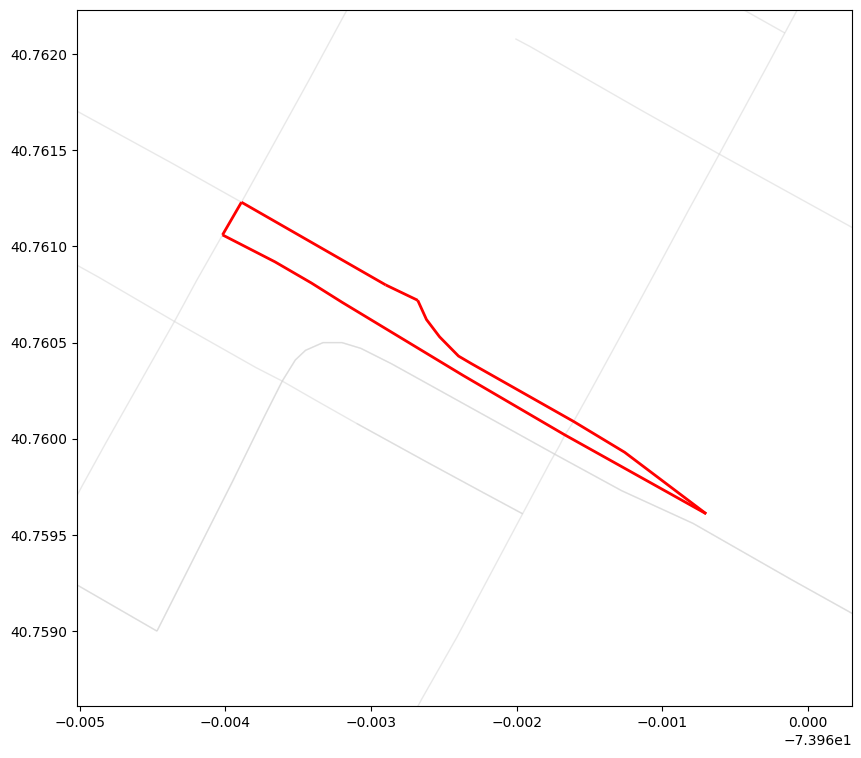

In [310]:
highlight_ids = k_cycles[5][13]

fig, ax = plt.subplots(figsize=(10, 10))

# base plot
gdf.plot(ax=ax, color="lightgray", linewidth=1, alpha=0.5)

# highlighted links
gdf.iloc[highlight_ids].plot(ax=ax, color="red", linewidth=2)

# ----- ZOOM ONTO HIGHLIGHTED AREA -----
# compute total bounds of all highlighted geometries
xmin, ymin, xmax, ymax = gdf.iloc[highlight_ids].total_bounds

# # optionally expand slightly (padding)
pad = 1e-3   # adjust meters/units as appropriate
ax.set_xlim(xmin - pad, xmax + pad)
ax.set_ylim(ymin - pad, ymax + pad)

plt.show()

In [26]:
test_graphs = np.array([
    [0, 1, 1, 1],
    [1, 0, 1, 1],
    [1, 1, 0, 1],
    [1, 1, 1, 0]
])

test_graphs = np.array([
    [0, 1, 0, 0],
    [1, 0, 1, 0],
    [0, 1, 0, 1],
    [0, 0, 1, 0]
])

In [27]:
build_motif_hypergraphs(test_graphs)

100%|██████████| 4/4 [00:00<00:00, 18078.90it/s]


{'triangles': array([], shape=(0, 3), dtype=int64),
 '3-stars': array([], shape=(0, 4), dtype=int64),
 '4-stars': array([], shape=(0, 5), dtype=int64),
 '3-paths': array([[0, 1, 2],
        [1, 2, 3]]),
 '4-paths': array([[0, 1, 2, 3]]),
 '4-cycles': array([], shape=(0, 4), dtype=int64)}

In [396]:
non_empty_mask = ~(y_batch == 0).all(dim=(0,1,3))  

In [411]:
gdf[~non_empty_mask.cpu().numpy()]

,TmcType,RoadNumber,RoadName,IsPrimary,FirstName,TmcLinear,Country,State,County,Zip,...,boro_code,boro_name,county_fip,ntacode,ntaname,shape_area,shape_le_1,LengthofIn,LengthInrx,geometry
Tmc,,,,,,,,,,,,,,,,,,,,,
120-54196,P1,None,FDR DR SERVICE RD E,1,FDR Dr S,54195,UNITED STATES,NEW YORK,NEW YORK,10016,...,1.0,Manhattan,061,MN19,Turtle Bay-East Midtown,1.738916e+07,21124.053857,0.0,96.131919,"LINESTRING (-73.97206 40.74319, -73.97184 40.7..."
120+54198,P1,None,None,1,FDR Dr,54195,UNITED STATES,NEW YORK,NEW YORK,10016,...,1.0,Manhattan,061,MN20,Murray Hill-Kips Bay,1.448587e+07,24491.310850,0.0,9.828538,"LINESTRING (-73.97206 40.74319, -73.97215 40.7..."
120P50971,P1,None,W 79TH ST,1,Columbus Ave,1144,UNITED STATES,NEW YORK,NEW YORK,10024,...,1.0,Manhattan,061,MN12,Upper West Side,3.437994e+07,29160.206532,0.0,17.600688,"LINESTRING (-73.97551 40.78196, -73.97569 40.7..."
120N50971,P1,None,W 79TH ST,1,Columbus Ave,1144,UNITED STATES,NEW YORK,NEW YORK,10024,...,1.0,Manhattan,061,MN12,Upper West Side,3.437994e+07,29160.206532,0.0,17.600688,"LINESTRING (-73.97569 40.78204, -73.97551 40.7..."
120N15742,P1,None,BROADWAY,1,Battery Pl/Bowling GRN,1247,UNITED STATES,NEW YORK,NEW YORK,10004,...,1.0,Manhattan,061,MN25,Battery Park City-Lower Manhattan,1.901430e+07,43738.496041,0.0,28.267718,"LINESTRING (-74.01412 40.7047, -74.01418 40.70..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120P50983,P1,None,E 45TH ST,1,2nd Ave,50982,UNITED STATES,NEW YORK,NEW YORK,10017,...,1.0,Manhattan,061,MN19,Turtle Bay-East Midtown,1.738916e+07,21124.053857,0.0,42.938665,"LINESTRING (-73.97081 40.75176, -73.97126 40.7..."
120N05373,P1,None,HUGH L CAREY TUNNEL,1,Trinity Pl/West Side Hwy,148,UNITED STATES,NEW YORK,NEW YORK,10004,...,1.0,Manhattan,061,MN25,Battery Park City-Lower Manhattan,1.901430e+07,43738.496041,0.0,44.428230,"LINESTRING (-74.01492 40.70605, -74.01512 40.7..."
120+16332,P1,None,GREENWICH ST,1,Rector St,1436,UNITED STATES,NEW YORK,NEW YORK,10006,...,1.0,Manhattan,061,MN25,Battery Park City-Lower Manhattan,1.901430e+07,43738.496041,0.0,64.355788,"LINESTRING (-74.01396 40.70711, -74.01372 40.7..."


In [412]:
road[~non_empty_mask.cpu().numpy()].shape

(207, 1212)

In [406]:
gdf[(gdf.TmcType == 'P1').values]

,TmcType,RoadNumber,RoadName,IsPrimary,FirstName,TmcLinear,Country,State,County,Zip,...,boro_code,boro_name,county_fip,ntacode,ntaname,shape_area,shape_le_1,LengthofIn,LengthInrx,geometry
Tmc,,,,,,,,,,,,,,,,,,,,,
120-15255,P1,None,7TH AVE S,1,Bleecker St/Barrow St,1110,UNITED STATES,NEW YORK,NEW YORK,10014,...,1.0,Manhattan,061,MN23,West Village,2.497065e+07,28621.651152,0.0,683.766486,"LINESTRING (-74.00019 40.73786, -74.00065 40.7..."
120-15254,P1,None,7TH AVE S,1,Clarkson St/Carmine St,1110,UNITED STATES,NEW YORK,NEW YORK,10014,...,1.0,Manhattan,061,MN23,West Village,2.497065e+07,28621.651152,0.0,321.450478,"LINESTRING (-74.0036 40.73228, -74.00382 40.73..."
120N15254,P1,None,7TH AVE S,1,Clarkson St/Carmine St,1110,UNITED STATES,NEW YORK,NEW YORK,10014,...,1.0,Manhattan,061,MN23,West Village,2.497065e+07,28621.651152,0.0,23.488514,"LINESTRING (-74.0051 40.72962, -74.00515 40.72..."
120+06893,P1,None,E 34TH ST,1,1st Ave,309,UNITED STATES,NEW YORK,NEW YORK,10016,...,1.0,Manhattan,061,MN20,Murray Hill-Kips Bay,1.448587e+07,24491.310850,0.0,64.846697,"LINESTRING (-73.97216 40.74323, -73.97221 40.7..."
120+06969,P1,None,1ST AVE,1,37th St,328,UNITED STATES,NEW YORK,NEW YORK,10016,...,1.0,Manhattan,061,MN20,Murray Hill-Kips Bay,1.448587e+07,24491.310850,0.0,161.433530,"LINESTRING (-73.97351 40.74378, -73.97321 40.7..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120-50799,P1,None,10TH AVE,1,W 207th St,50797,UNITED STATES,NEW YORK,NEW YORK,10034,...,1.0,Manhattan,061,MN01,Marble Hill-Inwood,1.773269e+07,31844.409421,0.0,733.051429,"LINESTRING (-73.9147 40.87024, -73.91517 40.86..."
120-50911,P1,None,LEXINGTON AVE,1,E 57th St,50905,UNITED STATES,NEW YORK,NEW YORK,10022,...,1.0,Manhattan,061,MN19,Turtle Bay-East Midtown,1.738916e+07,21124.053857,0.0,160.614382,"LINESTRING (-73.9682 40.76223, -73.96864 40.76..."
120P52154,P1,None,MADISON AVE,1,E 135th St,52136,UNITED STATES,NEW YORK,NEW YORK,10037,...,1.0,Manhattan,061,MN34,East Harlem North,2.449490e+07,30603.718884,0.0,48.718319,"LINESTRING (-73.93635 40.8117, -73.93602 40.81..."
